In [1]:
%load_ext autoreload
%autoreload 2

from dataloader import SwatDataset
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset

import wandb

import matplotlib.pyplot as plt

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
# col_list = [1, 2, 3, 4, 6, 12, 14, 16, 18, 21, 22, 24, 27, 28, 29, 33, 35, 42, 49]
col_list = list(range(51))

train_dataset = SwatDataset("./data/train_norm.npy", feature_idx=col_list, start_idx=10_000, end_idx=-1,
                             window_size=100, sliding=7)
val_dataset = SwatDataset("./data/validation_norm.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
                             window_size=100, sliding=100, labels_path="./data/labels_validation.npy")
test_dataset = SwatDataset("./data/test_norm.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
                             window_size=100, sliding=100, labels_path='./data/labels_test.npy')

len(train_dataset), len(val_dataset), len(test_dataset)

# train_dataset_minmax = SwatDataset("./data/train.npy", feature_idx=col_list, start_idx=10_000, end_idx=-1,
#                              window_size=100, sliding=7)
# val_dataset_minmax = SwatDataset("./data/validation.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
#                              window_size=100, sliding=100, labels_path="./data/labels_validation.npy")
# test_dataset_minmax = SwatDataset("./data/test.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
#                              window_size=100, sliding=100, labels_path='./data/labels_test.npy')

# len(train_dataset_minmax), len(val_dataset_minmax), len(test_dataset_minmax)

(69270, 402, 4092)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# train_loader = DataLoader(train_dataset_minmax, batch_size=128, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset_minmax, batch_size=128, shuffle=False)
# test_loader = DataLoader(test_dataset_minmax, batch_size=128, shuffle=False)

len(train_loader), len(val_loader), len(test_loader)

(1083, 7, 64)

In [9]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: a-gruzitski. Use `wandb login --relogin` to force relogin


True

## AE training

In [10]:
LEARNING_RATE = 1e-3
WEIGHT_DECAY= 0
WINDOW_SIZE = 100
NUM_EPOCHS = 60

run = wandb.init(
    project="anomaly-detection",
    config={
        "model": "AE Bottleneck scaling 16x, full feat, no act",
        "learning_rate": LEARNING_RATE,
        "epochs": NUM_EPOCHS,
        "window_size": WINDOW_SIZE,
        "weight_decay": WEIGHT_DECAY,
        "optimizer": "Adam",
        "scheduler" : "transf_warmup",
        "feat_num": "51"
    },
);


In [11]:
from models import TransformerBasicBottleneckScaling, TransformerBasicv2, TransformerBasicBottleneckScalingNoAct
from models import TransformerBasicBottleneck
from torch.optim import Adam, SGD
from training import train

from transformers import get_linear_schedule_with_warmup

criterion = torch.nn.MSELoss()  # mean reduction
 
# model = TransformerBasicBottleneckScaling(feats=len(col_list), 
#                                           window_size=100,
#                                           ).to(device)
model = TransformerBasicBottleneckScalingNoAct(feats=len(col_list), 
                                          window_size=100,
                                          ).to(device)

for p in model.parameters():
    if p.dim() > 1:
        torch.nn.init.xavier_uniform_(p)

optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4, steps_per_epoch=2, epochs=NUM_EPOCHS)

scheduler = get_linear_schedule_with_warmup(optimizer, 5, NUM_EPOCHS)

c:\Users\Andrew23\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [13]:
# model.load_state_dict(torch.load("checkpoints_\AE_no_act29e_x16_51feat.pt"))
# LEARNING_RATE = 1e-6
# NUM_EPOCHS = 1

data is ready!


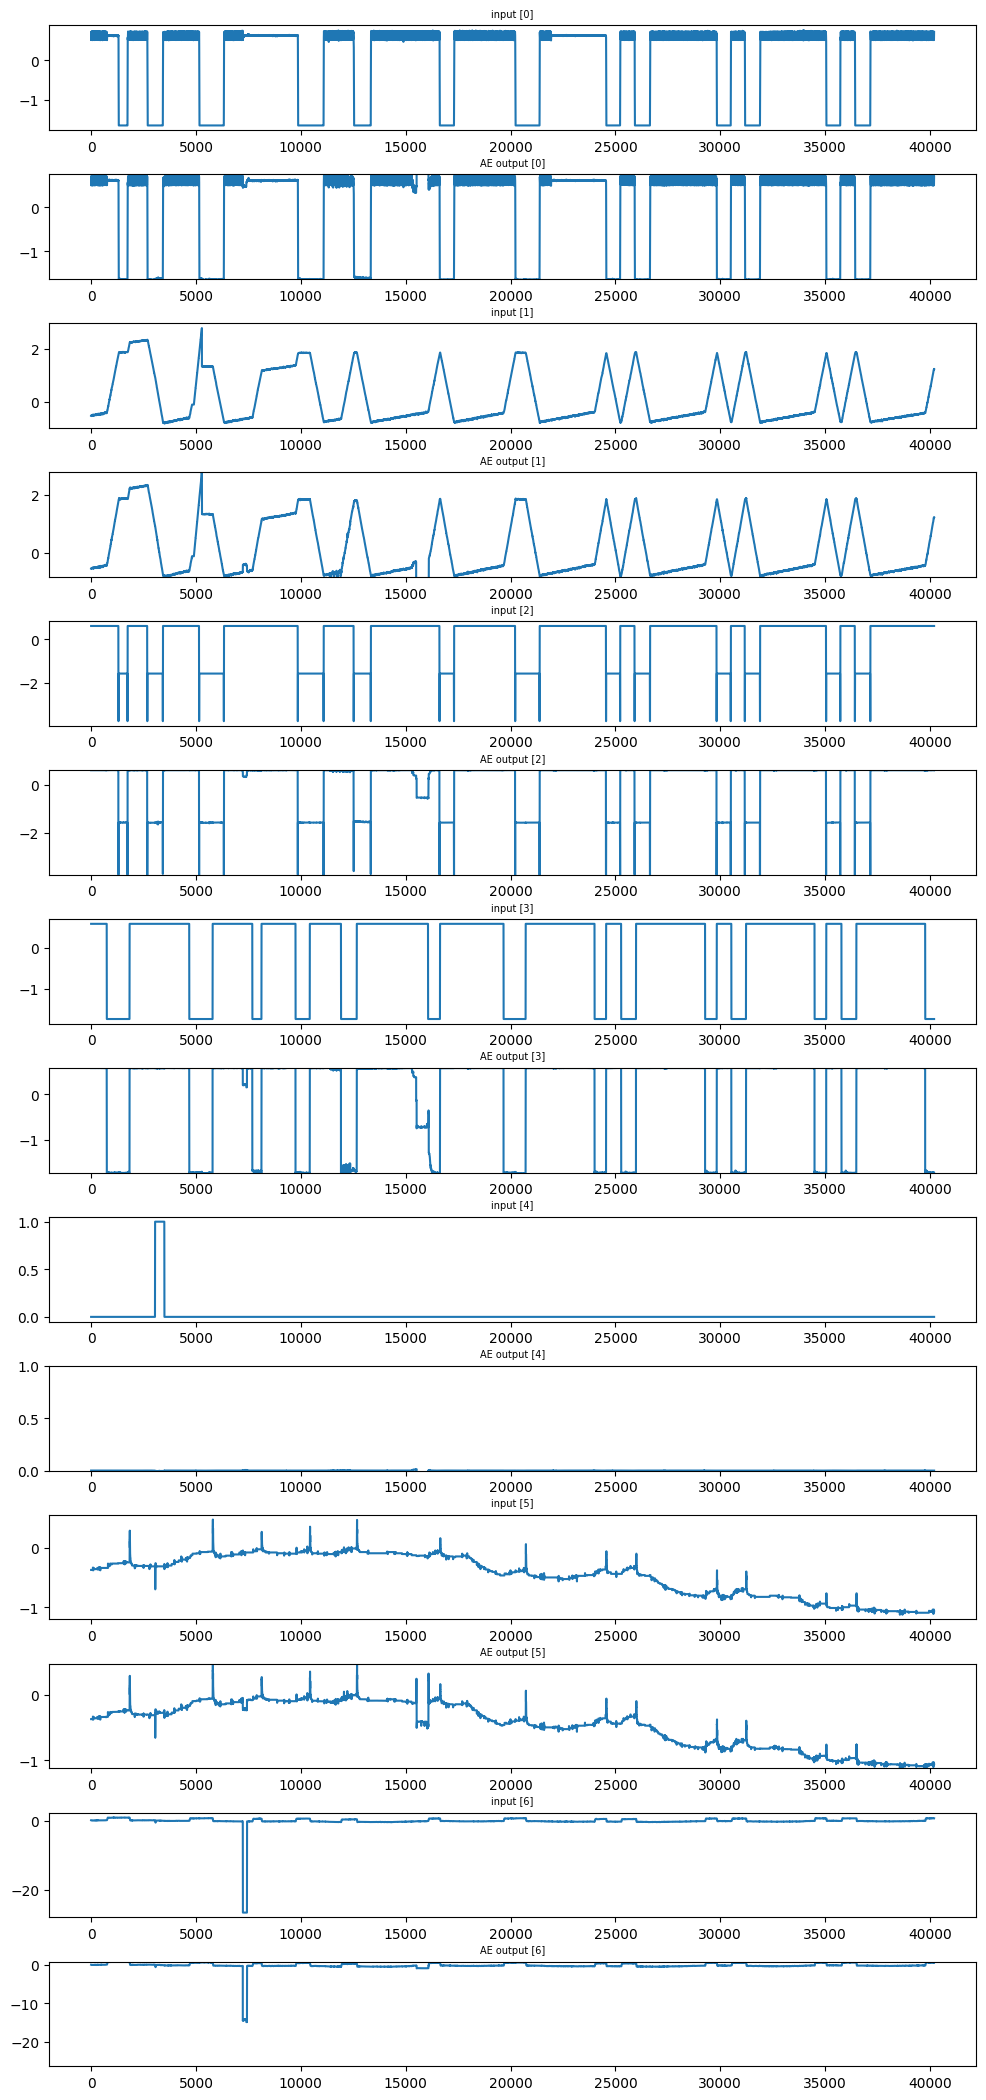

In [14]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, NUM_EPOCHS,
    device, start_epoch=0,
    save_checkpoints=True,
    val_labels_path="./data/labels_validation.npy",
    name_post="x16_51feat"
)

In [ ]:
torch.save(model.state_dict(), 'checkpoints\....pt')

## AE evaluation

## TSNE

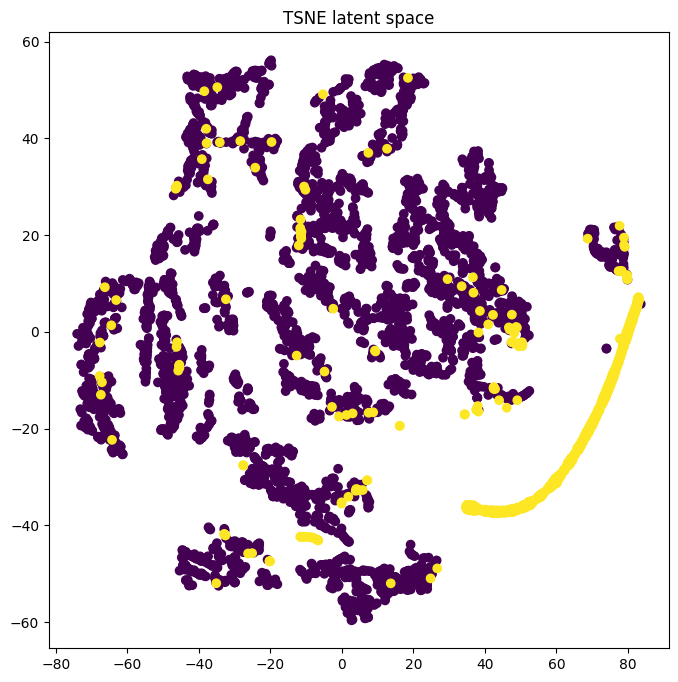

In [16]:
from collections import defaultdict

def get_representations(dataloader, encoder, device):
    representations = {0: [], 1: []}
    for feat, label in tqdm(dataloader, leave=False):
        feat= feat.to(device)
        embedding = encoder(feat)
        # print(int(label.sum() > 50), embedding.shape)
        
        representations[int(label.sum() > 97)].append(embedding.cpu().reshape(-1))
    return representations

# test_dataset_minmax = SwatDataset("./data/test.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
#                              window_size=100, sliding=100, labels_path='./data/labels_test.npy')
# test_loader_by_elements = DataLoader(test_dataset_minmax, batch_size=1, shuffle=False)


test_dataset = SwatDataset("./data/test_norm.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
                             window_size=100, sliding=100, labels_path='./data/labels_test.npy')
test_loader_by_elements = DataLoader(test_dataset, batch_size=1, shuffle=False)

representations = get_representations(test_loader_by_elements, model.get_latent_embedding, device=device)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)

vectors = torch.stack(representations[0] + representations[1], dim=0).cpu().detach().numpy()
embed = tsne.fit_transform(vectors)

colors = [0] * len(representations[0]) + [1] * len(representations[1])
plt.figure(figsize=(8, 8))
plt.scatter(embed[:, 0], embed[:, 1], c=colors)
plt.title('TSNE latent space')
plt.show()


## Metrics

In [20]:
import models
criterion = torch.nn.MSELoss()  
 
# model = models.AE_no_act_scale(feats=len(col_list), 
#                                           window_size=100,
#                                           ).to(device)

model = models.TransformerBasicBottleneckScalingNoAct(feats=len(col_list), 
                                          window_size=100,
                                          ).to(device)

model.load_state_dict(torch.load("checkpoints_\AE_no_act29e_x16_51feat.pt"))

<All keys matched successfully>

data is ready!


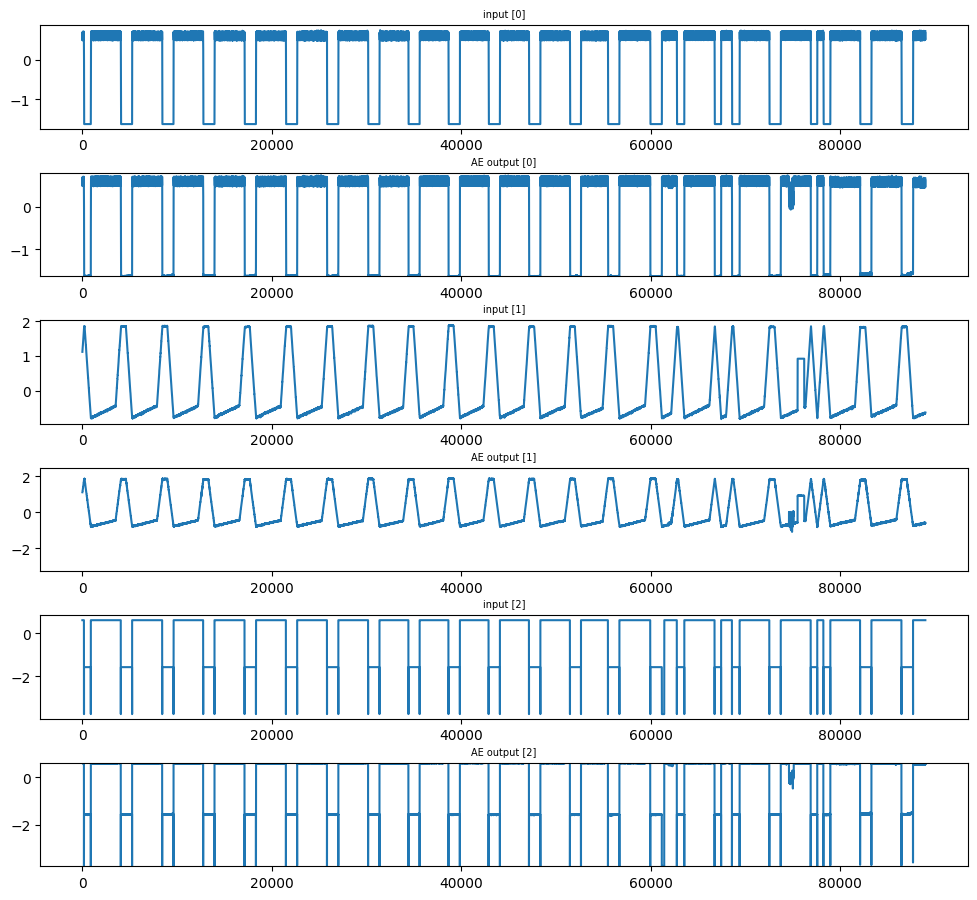

In [26]:
from training import plot_output

plot_output(model, test_loader, device=device, param_dim=51, max_plots=3,
            begin_idx=10_00, end_idx=90_000)  #   labels=np.load("./data/labels_val.npy"),

In [ ]:
# get validation threshold

import metrics_eval
from training import validation_epoch

val_labels = np.load("./data/labels_validation.npy")

_, _, full_test_loss, _ = validation_epoch(model, criterion, val_loader,
                      "getting full loss", 0, device=device)
loss_w = full_test_loss.mean(axis=2)
loss_w = loss_w.reshape(-1)

metrics_eval.evaluate(loss_w, val_labels)

In [27]:
import metrics_eval
from training import validation_epoch

test_labels = np.load("./data/labels_test.npy")

_, _, full_test_loss, _ = validation_epoch(model, criterion, test_loader,
                      "getting full loss", 0, device=device)

loss_w = full_test_loss.mean(axis=2)
loss_w = loss_w.reshape(-1)

test_res = metrics_eval.evaluate(loss_w, test_labels, 0.94)  # use validation threshold
test_res

getting full loss:   0%|          | 0/64 [00:00<?, ?it/s]

max loss score: 82.92688


100%|██████████| 50/50 [11:49<00:00, 14.19s/it]


{'f1': 0.6213192800494829,
 'ROC/AUC': 0.8857746097321256,
 'f1_max': 0.6363142977748296,
 'preds': array([False, False, False, ...,  True,  True,  True]),
 'k': 0,
 'thresh_max': 0.94,
 'roc_max': 0.8857746097321256}

## VAE training

In [28]:
LEARNING_RATE = 5e-4
WEIGHT_DECAY= 0
WINDOW_SIZE = 100
NUM_EPOCHS = 50

run = wandb.init(
    project="anomaly-detection_VAE",
    config={
        "model": "VAE no activation all features",
        "learning_rate": LEARNING_RATE,
        "epochs": NUM_EPOCHS,
        "window_size": WINDOW_SIZE,
        "weight_decay": WEIGHT_DECAY,
        "optimizer": "Adam",
        "scheduler" : "transf_warmup",
    },
);


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.99998
train_loss,0.00134
val_acc,0.92121
val_loss,0.00134


In [29]:
import models
from torch.optim import Adam, SGD
from training import train_vae

from transformers import get_linear_schedule_with_warmup

criterion = torch.nn.MSELoss()  # validation criterion
 
model = models.VAE_scale_no_act(feats=len(col_list), 
                        window_size=100).to(device)

for p in model.parameters():
    if p.dim() > 1:
        torch.nn.init.xavier_uniform_(p)

optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = get_linear_schedule_with_warmup(optimizer, 3, NUM_EPOCHS)

c:\Users\Andrew23\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [33]:
model.load_state_dict(torch.load("checkpoints_\VAE_scale_no_act_x16_60e.pt"))
# LEARNING_RATE = 1e-7
# NUM_EPOCHS = 

<All keys matched successfully>

In [ ]:
from training import train_vae

train_losses, test_losses = train_vae(
    model, optimizer, scheduler, criterion, train_loader, val_loader, NUM_EPOCHS,
    device, start_epoch=1,
    save_checkpoints=True,
    val_labels_path="./data/labels_validation.npy",
    name_post="x16"
)

data is ready!


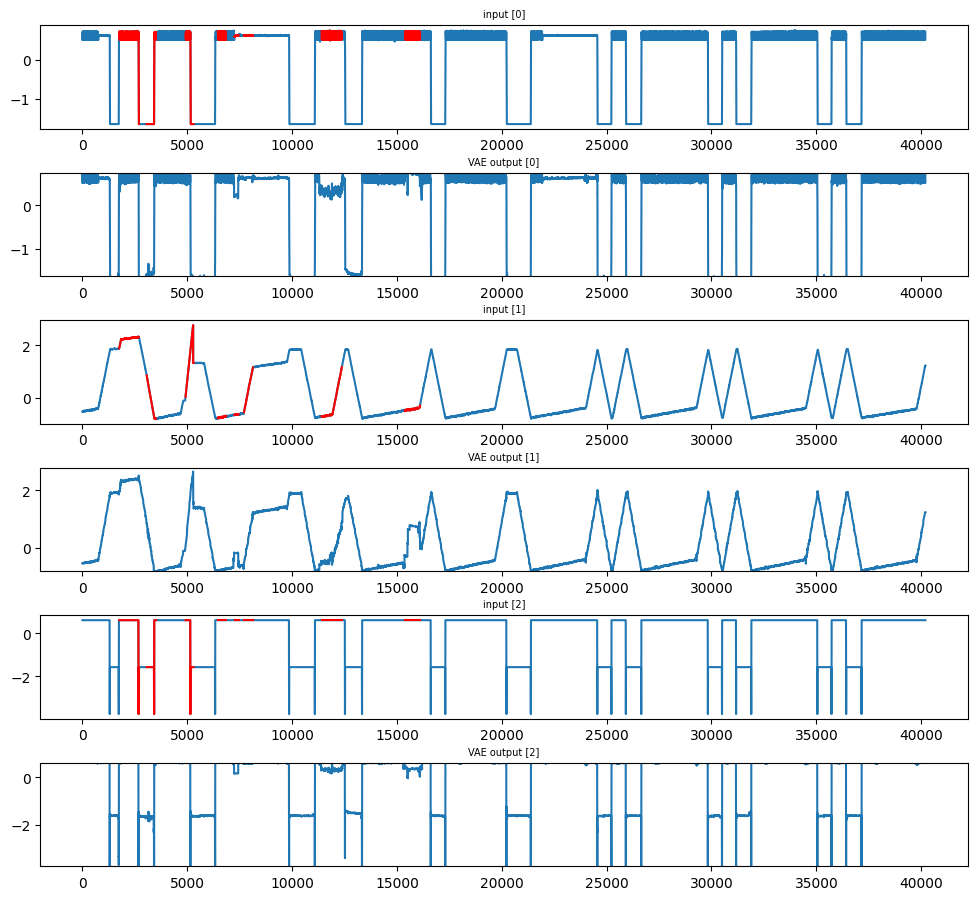

In [34]:
from training import plot_output

plot_output(model, val_loader, device=device, param_dim=51, max_plots=3, model_name="VAE",
             labels=np.load("./data/labels_validation.npy"))

In [41]:
torch.save(model.state_dict(), 'checkpoints/....pt')

## VAE evaluation

In [35]:
col_list = list(range(51))
# train_dataset_minmax = SwatDataset("./data/train.npy", feature_idx=col_list, start_idx=10_000, end_idx=-1,
#                              window_size=100, sliding=7)
# val_dataset_minmax = SwatDataset("./data/validation.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
#                              window_size=100, sliding=100, labels_path="./data/labels_validation.npy")
# test_dataset_minmax = SwatDataset("./data/test.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
#                              window_size=100, sliding=100, labels_path='./data/labels_test.npy')
train_dataset = SwatDataset("./data/train_norm.npy", feature_idx=col_list, start_idx=10_000, end_idx=-1,
                             window_size=100, sliding=7)
val_dataset = SwatDataset("./data/validation_norm.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
                             window_size=100, sliding=100, labels_path="./data/labels_validation.npy")
test_dataset = SwatDataset("./data/test_norm.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
                             window_size=100, sliding=100, labels_path='./data/labels_test.npy')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [36]:
import models

model = models.VAE_scale_no_act(feats=len(col_list), 
                        window_size=100).to(device)
model.load_state_dict(torch.load("checkpoints_\VAE_scale_no_act_x16_60e.pt"))

c:\Users\Andrew23\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

data is ready!


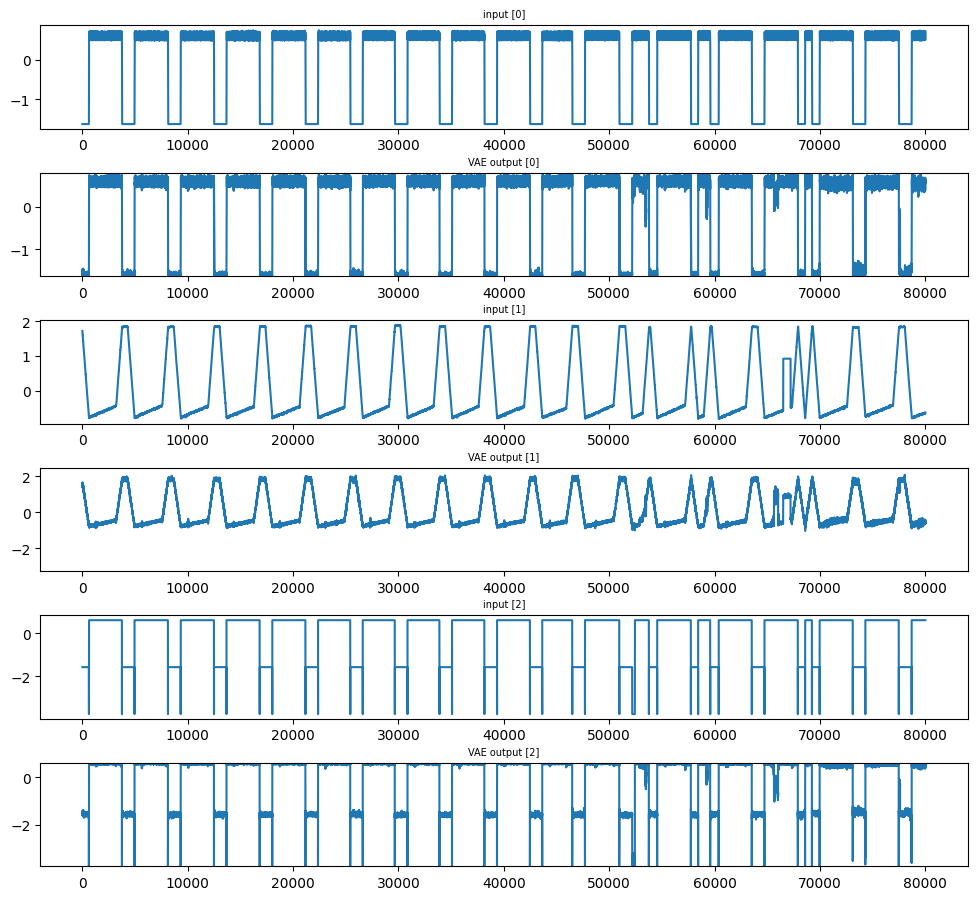

In [40]:
from training import plot_output

plot_output(model, test_loader, device=device, param_dim=51, max_plots=3, model_name="VAE", begin_idx=10_000, end_idx=90_000)
# plot_output(model, val_loader, device=device, param_dim=51, max_plots=3, model_name="VAE",
#              labels=np.load("./data/labels_validation.npy"))

In [ ]:
# get threshold from validation

import metrics_eval
from training import validation_vae_epoch

criterion = torch.nn.MSELoss()

val_labels = np.load("./data/labels_validation.npy")

_, full_test_loss, _ = validation_vae_epoch(model, criterion, val_loader,
                      "getting full loss", 0, device=device)
loss_w = full_test_loss.mean(axis=2)
loss_w = loss_w.reshape(-1)

metrics_eval.evaluate(loss_w, val_labels)

In [41]:
import metrics_eval
from training import validation_vae_epoch

test_labels = np.load("./data/labels_test.npy")

_, full_test_loss, _ = validation_vae_epoch(model, criterion, test_loader,
                      "getting full loss", 0, device=device)
loss_w = full_test_loss.mean(axis=2)
loss_w = loss_w.reshape(-1)

metrics_eval.evaluate(loss_w, test_labels, validation_thresh=1.62)  # use validation threshold

getting full loss:   0%|          | 0/64 [00:00<?, ?it/s]

max loss score: 91.86693


100%|██████████| 50/50 [12:03<00:00, 14.48s/it]


{'f1': 0.3942746990798567,
 'ROC/AUC': 0.8858339134201111,
 'f1_max': 0.40396443056534076,
 'preds': array([False, False, False, ...,  True,  True,  True]),
 'k': 0,
 'thresh_max': 1.62,
 'roc_max': 0.8858339134201111}

### TSNE

In [28]:
import models

model = models.VAE_act(feats=len(col_list), 
                        window_size=100).to(device)
model.load_state_dict(torch.load("checkpoints\...pt"))

c:\Users\Andrew23\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

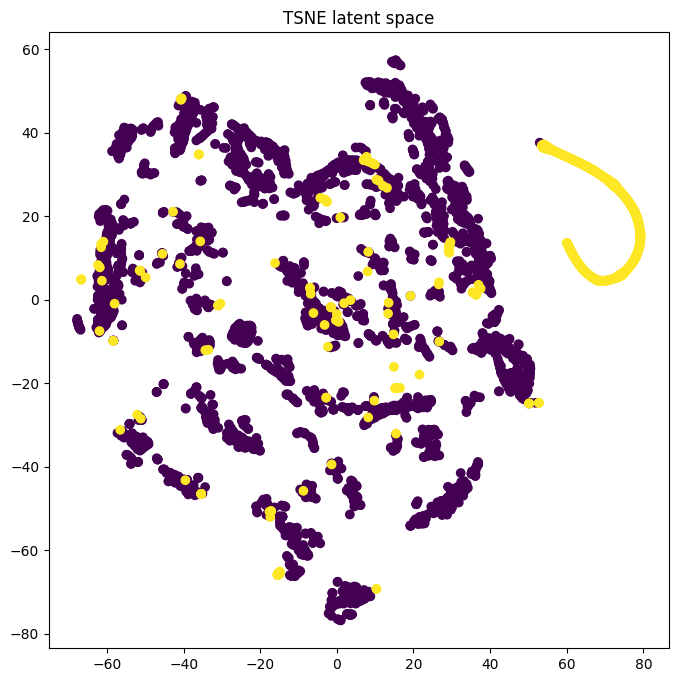

In [42]:
from collections import defaultdict

def get_representations(dataloader, encoder, device):
    representations = {0: [], 1: []}
    for feat, label in tqdm(dataloader, leave=False):
        feat= feat.to(device)
        embedding = encoder(feat)
        
        representations[int(label.sum() > 97)].append(embedding.cpu().reshape(-1))
    return representations

# val_dataset_minmax = SwatDataset("./data/validation.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
#                              window_size=100, sliding=100, labels_path='./data/labels_validation.npy')
# val_loader_by_elements = DataLoader(val_dataset_minmax, batch_size=1, shuffle=False)

# representations = get_representations(val_loader_by_elements, model.get_latent_embedding, device=device)

test_dataset = SwatDataset("./data/test.npy", feature_idx=np.arange(51), start_idx=0, end_idx=-1,
                             window_size=100, sliding=100, labels_path='./data/labels_test.npy')
test_loader_by_elements = DataLoader(test_dataset, batch_size=1, shuffle=False)

representations = get_representations(test_loader_by_elements, model.get_latent_embedding, device=device)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=23)

vectors = torch.stack(representations[0] + representations[1], dim=0).cpu().detach().numpy()
embed = tsne.fit_transform(vectors)

colors = [0] * len(representations[0]) + [1] * len(representations[1])
plt.figure(figsize=(8, 8))
plt.scatter(embed[:, 0], embed[:, 1], c=colors)
plt.title('TSNE latent space')
plt.show()
